# Context

The dataset used for this notebook is from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients or you can check it in https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608.

# Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:

* X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. <br>
* X2: Gender (1 = male; 2 = female). <br>
* X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). <br>
* X4: Marital status (1 = married; 2 = single; 3 = others). <br>
* X5: Age (year). <br>
* X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. <br>
* X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. <br>
* X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

# Importing all packages

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import shapiro, mannwhitneyu, chi2_contingency
import ppscore as pps

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, matthews_corrcoef, precision_score, recall_score, accuracy_score

from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Real, Integer

from yellowbrick.model_selection import LearningCurve

import warnings
warnings.filterwarnings("ignore") 

In [12]:
sns.set_style('whitegrid')

In [13]:
cc = pd.read_csv('UCI_Credit_Card.csv')
cc.shape

(30000, 25)

This dataset contains 30.000 observations with 25 features.

In [14]:
cc.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [15]:
pd.DataFrame({'dataFeatures' : cc.columns, 'dataType' : cc.dtypes.values, 
              'null' : [cc[i].isna().sum() for i in cc.columns],
              'nullPct' : [((cc[i].isna().sum()/len(cc[i]))*100).round(2) for i in cc.columns],
             'Nunique' : [cc[i].nunique() for i in cc.columns],
             'uniqueSample' : [list(pd.Series(cc[i].unique()).sample(2)) for i in cc.columns]}).reset_index(drop = True)

,dataFeatures,dataType,null,nullPct,Nunique,uniqueSample
0,ID,int64,0,0.0,30000,"[24194, 23057]"
1,LIMIT_BAL,float64,0,0.0,81,"[40000.0, 110000.0]"
2,SEX,int64,0,0.0,2,"[2, 1]"
3,EDUCATION,int64,0,0.0,7,"[5, 4]"
4,MARRIAGE,int64,0,0.0,4,"[3, 2]"
5,AGE,int64,0,0.0,56,"[61, 30]"
6,PAY_0,int64,0,0.0,11,"[7, 1]"
7,PAY_2,int64,0,0.0,11,"[-1, 5]"
8,PAY_3,int64,0,0.0,11,"[8, 2]"
9,PAY_4,int64,0,0.0,11,"[6, 0]"


No missing values! Before I explore the dataset, I'll rename the target column first. 

In [16]:
cc.rename(columns = {'default.payment.next.month' : 'target'}, inplace = True)

In [17]:
cc.dtypes

ID             int64
LIMIT_BAL    float64
SEX            int64
EDUCATION      int64
MARRIAGE       int64
AGE            int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
target         int64
dtype: object

Much better...

# Exploration Data Analysis

In [18]:
cc['target'].value_counts(normalize = True)

0    0.7788
1    0.2212
Name: target, dtype: float64

Percentage of default is: 22.12%  

## Hypothesis Testing

Before we go further, i'll do significance test first. But significance test required normality test, to know the data whether normally distribute or not. I'll use shapiro-wilk test to do normality test. 

### Normality Test

It's a little bit tricky, we need to know, what features is numerical or categorical. 

In [19]:
cc.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [20]:
numerical = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
            'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
            'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [21]:
shap = []

for i in numerical:
    if shapiro(cc[i])[1] < 0.05:
        shap.append('Reject Null Hypothesis')
    else:
        shap.append('Fail To reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : shap}, index = numerical)

/home/user/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Hypothesis
LIMIT_BAL,Reject Null Hypothesis
AGE,Reject Null Hypothesis
BILL_AMT1,Reject Null Hypothesis
BILL_AMT2,Reject Null Hypothesis
BILL_AMT3,Reject Null Hypothesis
BILL_AMT4,Reject Null Hypothesis
BILL_AMT5,Reject Null Hypothesis
BILL_AMT6,Reject Null Hypothesis
PAY_AMT1,Reject Null Hypothesis
PAY_AMT2,Reject Null Hypothesis


### Significance Test

Let's do mannwhitneyu Test then...

In [22]:
mann = []

for i in numerical:
    if mannwhitneyu(cc[cc['target'] == 0][i],cc[cc['target'] == 1][i])[1] < 0.05:
        mann.append('Reject Null Hypothesis')
    else:
        mann.append('Fail To Reject Null Hypothesis')
    
pd.DataFrame(mann, columns = ['Hypothesis'], index = numerical)

,Hypothesis
LIMIT_BAL,Reject Null Hypothesis
AGE,Fail To Reject Null Hypothesis
BILL_AMT1,Reject Null Hypothesis
BILL_AMT2,Reject Null Hypothesis
BILL_AMT3,Reject Null Hypothesis
BILL_AMT4,Fail To Reject Null Hypothesis
BILL_AMT5,Fail To Reject Null Hypothesis
BILL_AMT6,Fail To Reject Null Hypothesis
PAY_AMT1,Reject Null Hypothesis
PAY_AMT2,Reject Null Hypothesis


#### Chi2 Test

In [23]:
for i in ['ID', 'target']:
    numerical.append(i)

In [24]:
categorical = cc.drop(numerical, axis = 1).columns

In [25]:
chi2 = []

for i in categorical:
    if chi2_contingency(pd.crosstab(cc['target'], cc[i]))[1] < 0.05:
        chi2.append('Reject Null Hypothesis')
    else:
        chi2.append('Fail To Reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : chi2}, index = categorical)

,Hypothesis
SEX,Reject Null Hypothesis
EDUCATION,Reject Null Hypothesis
MARRIAGE,Reject Null Hypothesis
PAY_0,Reject Null Hypothesis
PAY_2,Reject Null Hypothesis
PAY_3,Reject Null Hypothesis
PAY_4,Reject Null Hypothesis
PAY_5,Reject Null Hypothesis
PAY_6,Reject Null Hypothesis


From the significance test, we know AGE and amount of bill statement in June, May, and April are not significance (difference). My recommendation, focus on amount of bill statement in September, August, and July.

Wait, AGE is not significance? That's interesting. But why? I thought, younger people will defaulting more. Let's visualize it. 

Text(0.5, 1.0, 'Age distribution')

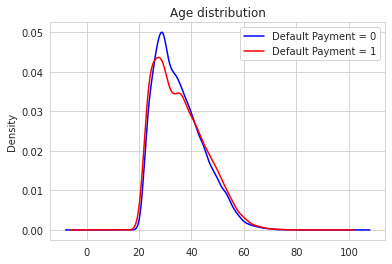

In [26]:
cc[cc['target'] == 0]['AGE'].plot(kind = 'kde', color = 'blue', label = 'Default Payment = 0')
cc[cc['target'] == 1]['AGE'].plot(kind = 'kde', color = 'red', label = 'Default Payment = 1')
plt.legend()
plt.title('Age distribution')

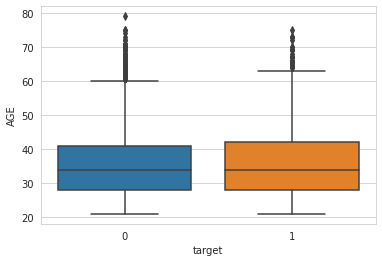

In [27]:
sns.boxplot(y = cc['AGE'], x = cc['target'])

Oh! I see! Almost no difference at all in age distributions between defaulters and not. That's so suprising. Thanks to Significance Test. 

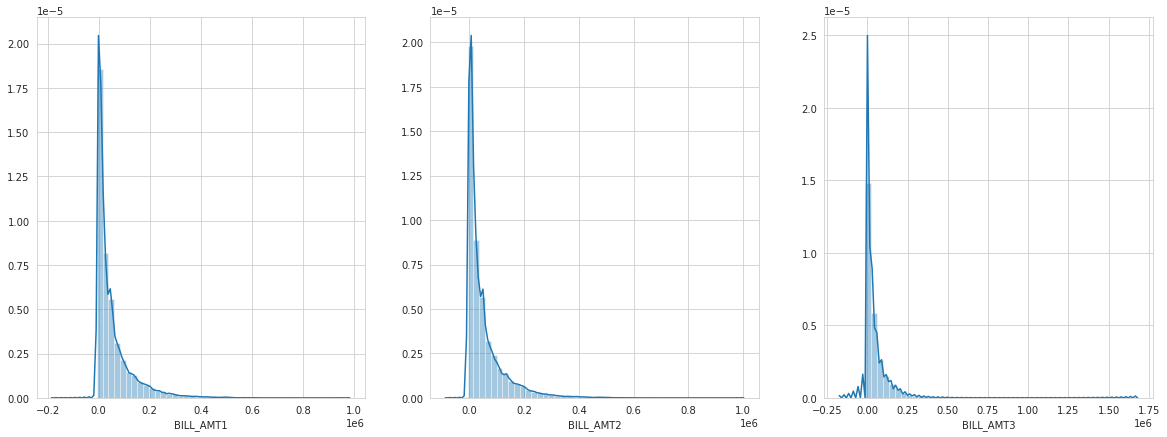

In [28]:
fig, ax = plt.subplots(1, 3, figsize = (20, 7))

for i,j in zip(ax.flatten(), ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']):
    sns.distplot(cc[j], ax = i)

The pattern between amount of bill statement in September, August, and July looks same. And that's make sense, most people don't want have too much debt and the vast majority of people have debt below about NT$ 50.000. How about the limit balanced? Let me guess, I think, people with lower limit balanced are more likely defaulting. Prove me wrong please... 

Text(0.5, 1.0, 'LIMIT_BAL distribution')

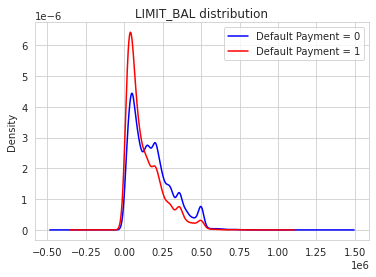

In [29]:
cc[cc['target'] == 0]['LIMIT_BAL'].plot(kind = 'kde', color = 'blue', label = 'Default Payment = 0')
cc[cc['target'] == 1]['LIMIT_BAL'].plot(kind = 'kde', color = 'red', label = 'Default Payment = 1')
plt.legend()
plt.title('LIMIT_BAL distribution')

:( it's not suprising at all. The lower limit balanced are more likely defaulting then people with higher limit balanced. Why this make sense? Cause If bank seems 'don't trust' you or they see you're a 'high risk' applicant, bank usually will only give you a smaller line of credit. Does education significance (quantitively)?

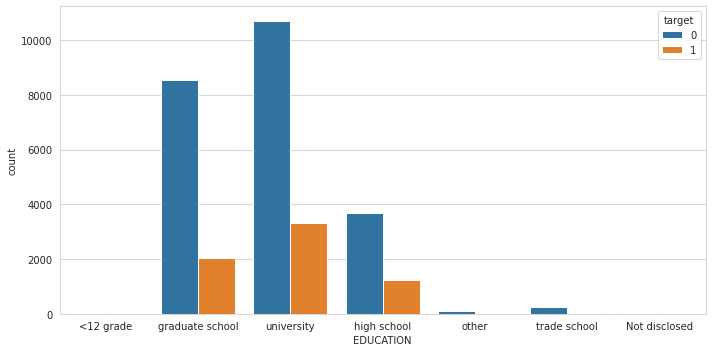

In [30]:
plt.figure(figsize = (10, 5))
sns.countplot(cc['EDUCATION'], hue = cc['target'])
plt.xticks((0,1,2,3,4,5,6),('<12 grade','graduate school','university',
                            'high school','other','trade school','Not disclosed'))
plt.tight_layout()

In this observations, our debtors are mostly educated people. Let's do feature selection using Predictive Power Scoring...

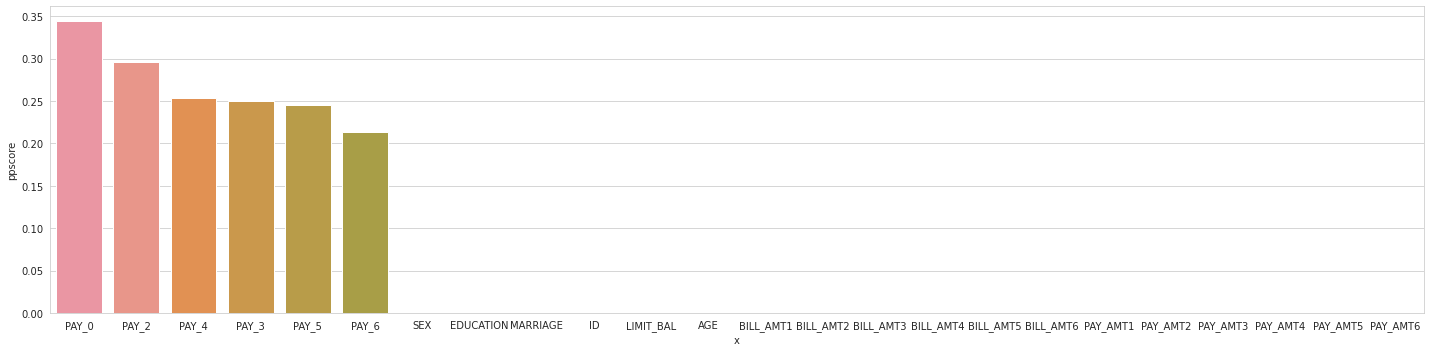

In [31]:
plt.figure(figsize = (20, 5))
df_predictors = pps.predictors(cc, y="target")
sns.barplot(data=df_predictors, x="x", y="ppscore")
plt.tight_layout()

That's interesting, history of payment features will help model to predictive whether the debtors will defaulting or not. 

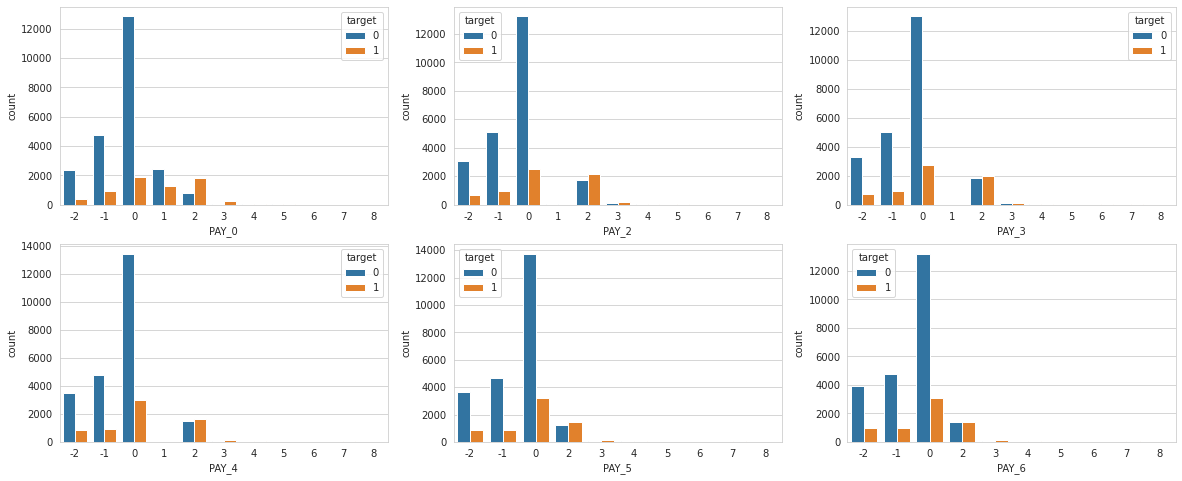

In [32]:
fig, ax = plt.subplots(2,3, figsize = (20, 8))

for i,j in zip([0,2,3,4,5,6],ax.flatten()):
    sns.countplot(cc['PAY_{}'.format(i)], hue = cc['target'], ax = j)

Seems they all look same. This plot tell us, that not everyone pays their debt on time.  But for the debtors that are already late in a few monts, it looks like they're more likely to end up in default than debtors who end up paying off their debt. 

# Dataset Splitting

In [33]:
X = cc.drop(columns = 'target')
y = cc['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24000, 24), (6000, 24), (24000,), (6000,))

# Preprocessing

In [34]:
categorical = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer([
    ('cat', categorical, ['PAY_{}'.format(i) for i in [0,2,3,4,5,6]])
])

# Modeling

In [83]:
def evaluationMetrics(y_test, y_pred):
    f1.append(f1_score(y_test,y_pred))
    prec.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    auc.append(roc_auc_score(y_test, y_pred))
    acc.append(accuracy_score(y_test, y_pred))
    matthews.append(matthews_corrcoef(y_test, y_pred))

In [84]:
metric = pd.DataFrame(index = ['AdaBoost Classifier', 'KNN Classifier', 'XGBoost Classifier']) 
f1 = []
prec = []
recall = []
matthews = []
auc = []
acc = []

## Adaboost

In [54]:
ada_params = {
    'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
    'algo__n_estimators': Integer(low=100, high=200)
}

In [55]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', AdaBoostClassifier())
])

ada = RandomizedSearchCV(pipeline, ada_params, cv = 3, n_jobs = -1, random_state = 101)
ada.fit(X_train, y_train)

print(ada.best_params_)
print(ada.score(X_train, y_train), ada.best_score_, ada.score(X_test, y_test))

{'algo__learning_rate': 0.36122336008063605, 'algo__n_estimators': 105}
0.8197083333333334 0.8192083333333334 0.8256666666666667


In [85]:
y_pred_ada = ada.best_estimator_.predict(X_test)
evaluationMetrics(y_test, y_pred_ada)

## KNN

In [57]:
knn_params = {
    'algo__n_neighbors': Integer(low=1, high=20),
}

In [58]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

knn = RandomizedSearchCV(pipeline, knn_params, cv = 3, n_jobs = -1, random_state = 101)
knn.fit(X_train, y_train)

print(knn.best_params_)
print(knn.score(X_train, y_train), knn.best_score_, knn.score(X_test, y_test))

{'algo__n_neighbors': 16}
0.8184166666666667 0.8162916666666667 0.8191666666666667


In [86]:
y_pred_knn = knn.best_estimator_.predict(X_test)
evaluationMetrics(y_test, y_pred_knn)

## XGBoost Classifier

In [63]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier())
])

xgb = RandomizedSearchCV(pipeline, rsp.xgb_params, cv = 3, n_jobs = -1, random_state = 101)
xgb.fit(X_train, y_train)

print(xgb.best_params_)
print(xgb.score(X_train, y_train), xgb.best_score_, xgb.score(X_test, y_test))

{'algo__colsample_bytree': 0.14363608368376052, 'algo__gamma': 8, 'algo__learning_rate': 0.4501489968769524, 'algo__max_depth': 9, 'algo__n_estimators': 162, 'algo__reg_alpha': 0.2573510611415207, 'algo__reg_lambda': 0.23179283837105844, 'algo__subsample': 0.5208429341570253}
0.821125 0.8199166666666667 0.8258333333333333


In [87]:
y_pred_xgb = xgb.best_estimator_.predict(X_test)
evaluationMetrics(y_test, y_pred_xgb)

# Evaluation

## Metrics

In [88]:
metric['F1'] = f1
metric['Precision'] = prec
metric['Recall'] = recall
metric['MCC'] = matthews
metric['AUC'] = auc
metric['accuracy'] = acc

In [89]:
metric

,F1,Precision,Recall,MCC,AUC,accuracy
AdaBoost Classifier,0.485236,0.699291,0.371515,0.420359,0.663074,0.825667
KNN Classifier,0.440433,0.697712,0.321778,0.386976,0.641095,0.819167
XGBoost Classifier,0.490989,0.694215,0.379804,0.422884,0.666149,0.825833


## Confusion Matrix

### Adaboost

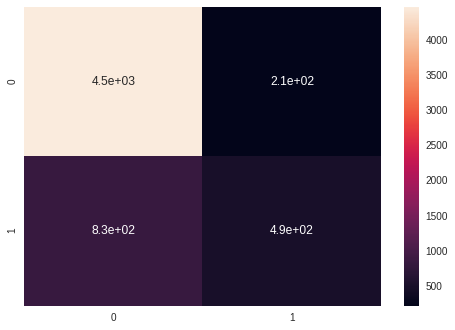

In [104]:
sns.heatmap(confusion_matrix(y_test, y_pred_ada), annot = True)

### KNN

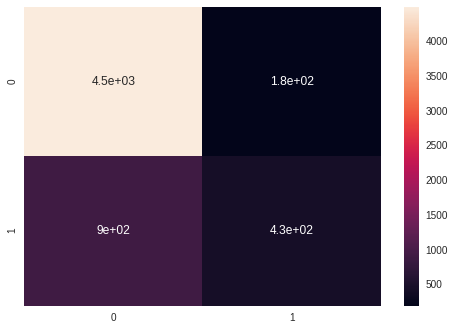

In [103]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot = True)

### XGBoost

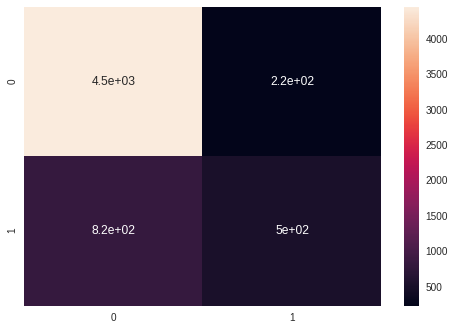

In [102]:
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot = True)

## Learning Curves

### Adaboost

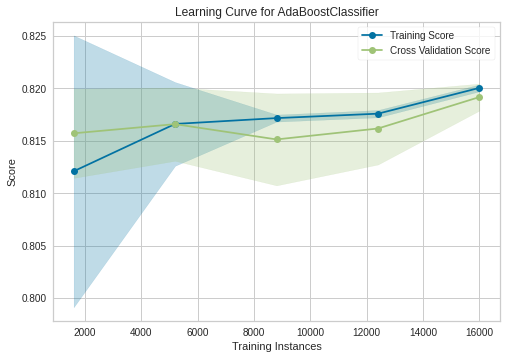

In [95]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    ada.best_estimator_, scoring = 'accuracy', train_size = sizes, random_state = 101,  cv = 3
)

visualizer.fit(X_train, y_train)
visualizer.show()

### KNN

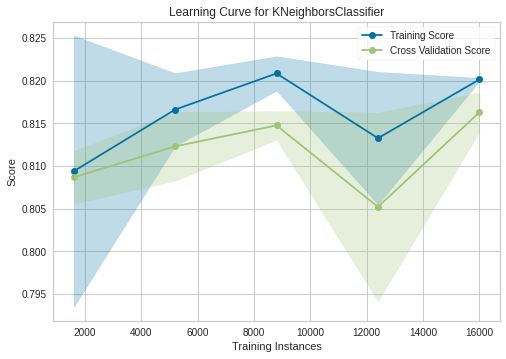

In [94]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    knn.best_estimator_, scoring = 'accuracy', train_size = sizes, random_state = 101,  cv = 3
)

visualizer.fit(X_train, y_train)
visualizer.show()

### XGBoost

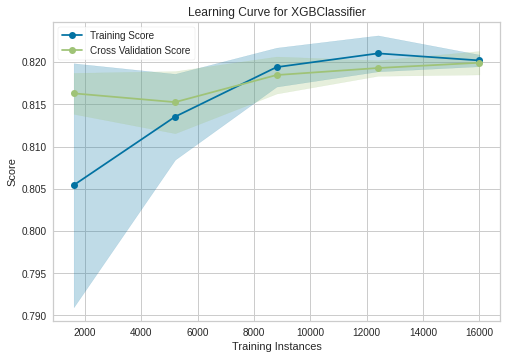

In [97]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    xgb.best_estimator_, scoring = 'accuracy', train_size = sizes, random_state = 101,  cv = 3
)

visualizer.fit(X_train, y_train)
visualizer.show()

# Conclusion

Our best model is XGBoost with 82-83% accuracy and if we see to his learning curve, its a good fit.

# Thank you